In [1]:
import ase
import matplotlib.pyplot as plt
import numpy as np
from abtem.transfer import polar_symbols

import abtem

abtem.config.set({"local_diagnostics.progress_bar": False})

# Contrast Transfer function (CTF)

### Intro

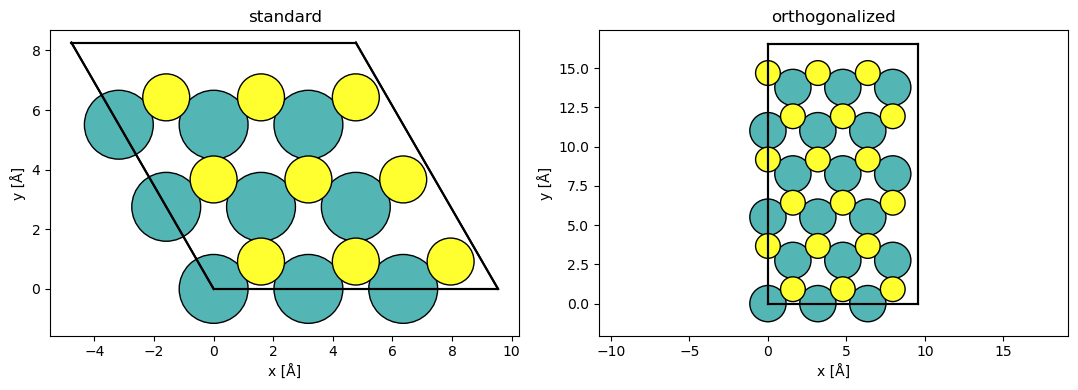

In [2]:
#creation of mx2 structure (f.e. MoS2) with surrounding vacuum layer
atoms = ase.build.mx2(vacuum=2)
#orthogonalize structure via abTEM (repeats structure until orth EZ possible), because -> will mit orthogonaler Zelle arbeiten
atoms_orth = abtem.orthogonalize_cell(atoms)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(11,4))
abtem.show_atoms(atoms*(3,3,3), ax=ax1, title='standard')
abtem.show_atoms(atoms_orth*(3,3,3), ax=ax2, title='orthogonalized')
plt.tight_layout()

defocus = -111.92 Å


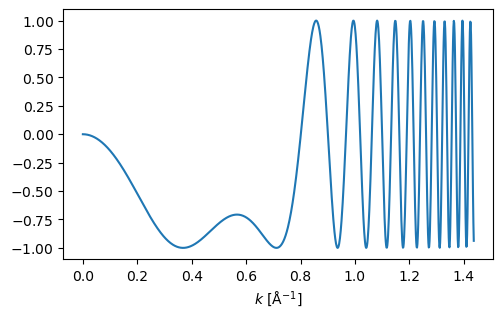

In [3]:
#run plane wave through default potential (lobato)
exit_wave = abtem.PlaneWave(energy=80e3, sampling=0.02).multislice(atoms)

#create compatible ctf for electrons with energy 80 keV..
Cs = -20e-6 * 1e10  # 20 micrometers, WH: Cs = third order spherical aberration
ctf = abtem.CTF(Cs=Cs, energy=80e3, defocus="scherzer")
print(f"defocus = {ctf.defocus:.2f} Å")

#.. or alternatively use dict
aberration_coefficients = {"C10": -ctf.defocus, "C30": Cs}
ctf = abtem.CTF(aberration_coefficients=aberration_coefficients, energy=ctf.energy)

#view radial line profile of ctf of a given angle (by convention display of imaginary part of the phase error: exp(i*chi), where chi is abberation)
ctf.profiles(max_angle=60).show(units='mrad', figsize=(5,3)) 

#interpretation plot -> stark variierende Kontraste 

In [5]:
type(ctf)

abtem.transfer.CTF

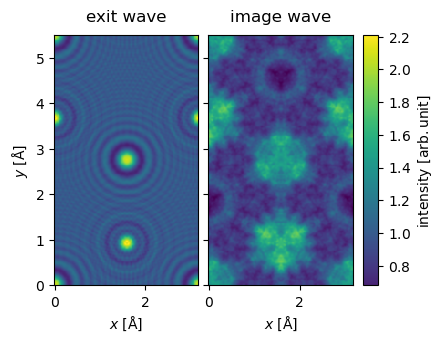

In [4]:
#create image wave (multiplying exit wave by exp(-i chi))
image_wave = exit_wave.apply_ctf(ctf)

#abtem.stack([exit_wave, image_wave], ['exit wave', 'image wave']).show(cbar=True, common_color_scale=True, figsize=(6,3))
abtem.stack([exit_wave, image_wave], ['exit wave', 'image wave']).show(explode=True, cbar=True, common_color_scale=True, figsize=(6,3))

In [5]:
#how/where does .show() above find the headings?
test = abtem.stack([exit_wave, image_wave], ("Exit wave", "Aberrated wave"))
test1 = abtem.stack([exit_wave, image_wave])
print(f'test shape: {test.shape}; test type:{test.dtype}')
print(f'test1 shape: {test1.shape}; test1 type:{test1.dtype}')

test shape: (2, 159, 276); test type:<class 'numpy.complex64'>
test1 shape: (2, 159, 276); test1 type:<class 'numpy.complex64'>


### Series

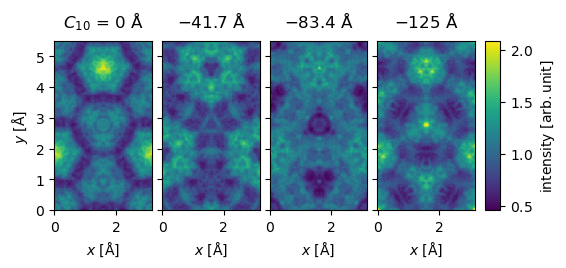

In [6]:
#testing different variations, realistically specifics often unknown
ctf_series = abtem.CTF(Cs=-25e-6 * 1e10, energy=80e3)
#create defocus series (C10 = defocus, see above or documentation)
ctf_series.C10 = np.linspace(0, ctf_series.scherzer_defocus, 4)
#apply contrast tranfer funcion with varying defoci to wave
image_wave_series = exit_wave.apply_ctf(ctf_series)

#plot
image_wave_series.show(explode=True, common_color_scale=True, cbar=True)

### Aperture

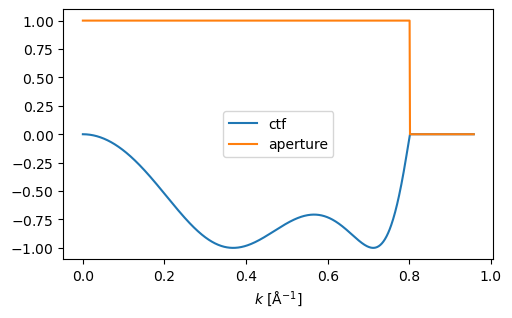

In [21]:
#maximum tranferred frequency is limited by the aperture of the objective lens 
#(mathematisch realisiert durch charakteristische Funktion; =1 innerhalb eines bestimmten Bereichs, =0 sonst)
ctf_aperture = ctf.copy()

#define cutoff frequency at point where the CTF crosses the "x-achse" for the first time = angle corresponding to the Scherzer point resolution - aka crossover angle
ctf_aperture.semiangle_cutoff = ctf_aperture.crossover_angle

#plot
ctf_aperture.profiles(max_angle=40).show(legend=True, units='mrad', figsize=(5,3))

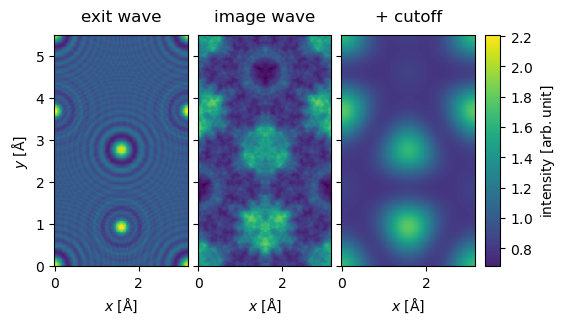

In [8]:
#apply limited ctf
image_wave_aperture = exit_wave.apply_ctf(ctf_aperture)

#pretty plot
abtem.stack([exit_wave, image_wave, image_wave_aperture], ['exit wave', 'image wave', '+ cutoff']).show(explode=True, cbar=True, common_color_scale=True)

### Asymmetric Aberrations

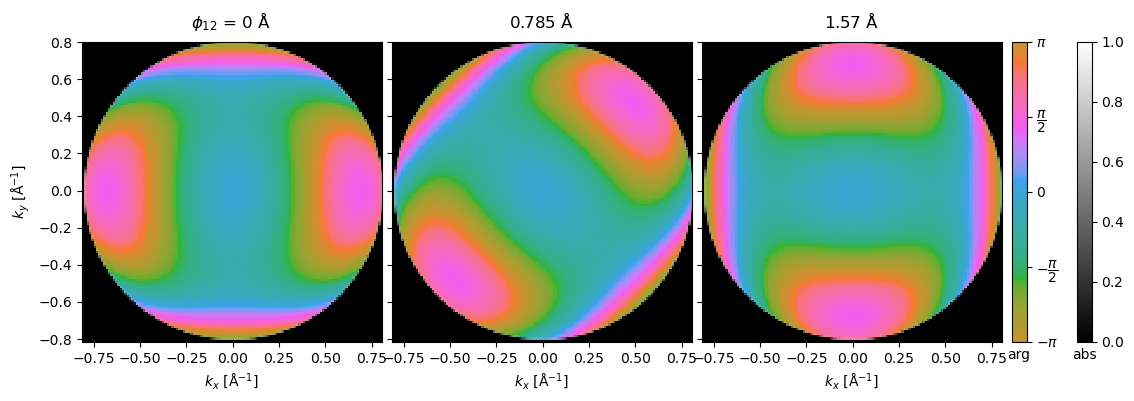

In [35]:
#create Astigmatism of 50 A° from 0 to pi/2, (astig=wölbung)
ctf_astig = ctf_aperture.copy()

ctf_astig.astigmatism = 50
ctf_astig.astigmatism_angle = np.linspace(0, np.pi /2 , 3)

#visualizing in recicprocal space
measurements = ctf_astig.to_diffraction_patterns(max_angle=ctf_aperture.crossover_angle * 1.01)
visualization = measurements.show(explode=True, figsize=(12, 4), cbar=True, common_color_scale=True)

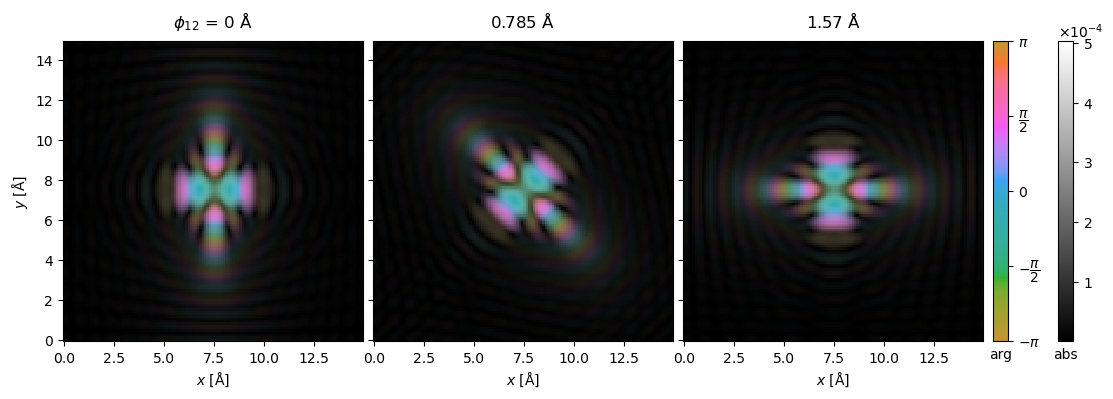

In [33]:
#PSF We can also visualize each phase aberration by showing its effect on a small probe wave function. 
#This is called the point spread function (PSF) and describes the response of an imaging system to a point source. 
psf = ctf_astig.to_point_spread_functions(gpts=128, extent=15).compute()
psf.show(explode=True, figsize=(12, 4), cbar=True, common_color_scale=True)
#psf.show(explode=True, figsize=(12, 4), cbar=True, common_color_scale=True, vmax=0.51e-3, cmap="hsluv")

### Partial Coherence

In [36]:
#[..] -> adding additional envelope functions so consider spatial and temporal coherence effects [..]
#calculating focal spread, see doc:https://abtem.readthedocs.io/en/latest/user_guide/walkthrough/contrast_transfer_function.html#partial-temporal-coherence
Cc = 1.2e-3 * 1e10
energy = exit_wave.energy
energy_spread = 0.35

focal_spread = Cc * energy_spread / energy

print(f"focal spread = {focal_spread:.2f} Å")

focal spread = 52.50 Å


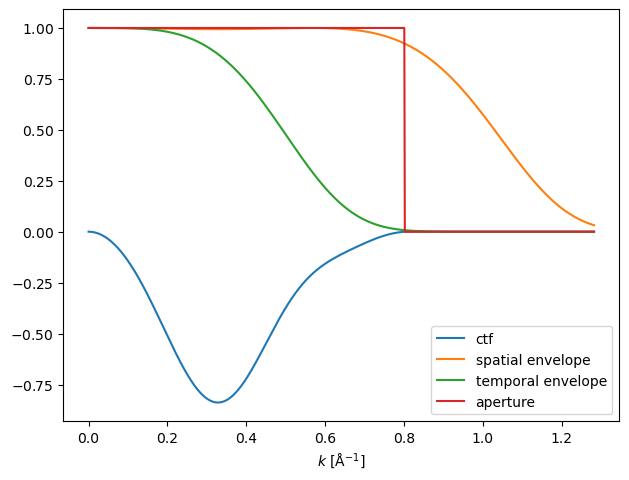

In [37]:
#
ctf_partial = ctf_aperture.copy()
ctf_partial.focal_spread = focal_spread#zeitl Kohärenz
ctf_partial.angular_spread = 1 #räumliche Kohärenz
ctf_partial.profiles().show(units="mrad", legend=True);

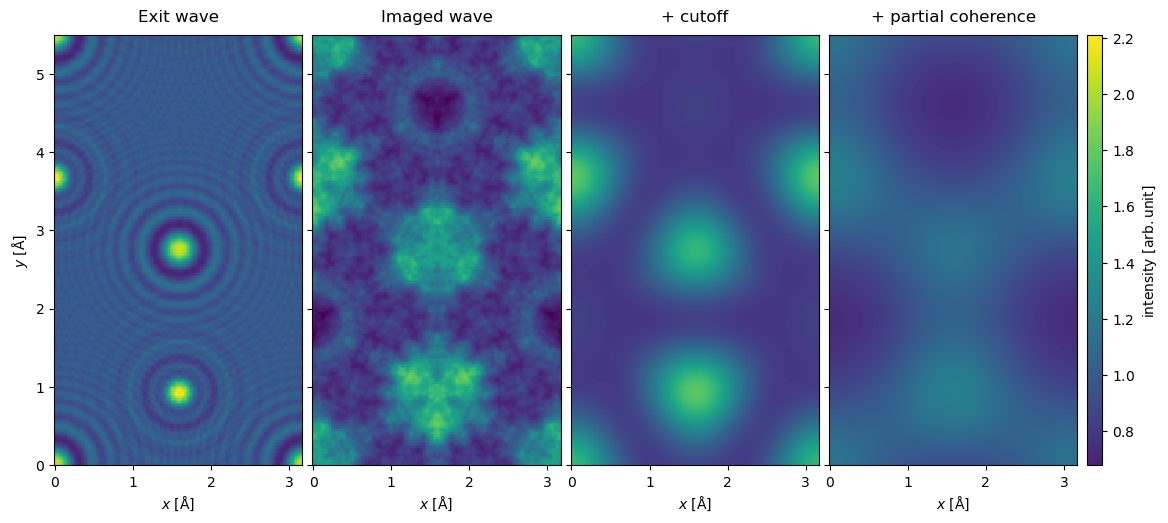

In [43]:
#applying coherence aberrations
wave_partial = exit_wave.apply_ctf(ctf_partial)

#..and show
vis = abtem.stack([exit_wave, image_wave, image_wave_aperture, wave_partial], ("Exit wave", "Imaged wave", "+ cutoff", "+ partial coherence"),).show(
    explode=True, figsize=(14, 5), common_color_scale=True, cbar=True)